In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

%matplotlib inline

matplotlib.rcParams["figure.facecolor"] = "#ffffff"

## Prepare the dataset

In [2]:
data_dir = "./data/cifar10"
classes = os.listdir(data_dir + "/train")

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.

2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [3]:
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


train_ds = ImageFolder(data_dir + "/train", T.Compose([T.ToTensor()]))
train_dl = DataLoader(
    train_ds, batch_size=512, shuffle=True, num_workers=4, pin_memory=True
)
stats = get_mean_std(train_dl)
print(stats)

100%|██████████| 98/98 [00:15<00:00,  6.39it/s](tensor([0.4914, 0.4821, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))



In [4]:
train_transforms = T.Compose(
    [
        T.RandomCrop(32, padding=4, padding_mode="reflect"),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(*stats, inplace=True),
    ]
)

valid_transforms = T.Compose([T.ToTensor(), T.Normalize(*stats)])

train_ds = ImageFolder(data_dir + "/train", train_transforms)
valid_ds = ImageFolder(data_dir + "/test", valid_transforms)

batch_size = 512

train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True
)
valid_dl = DataLoader(valid_ds, batch_size * 2, num_workers=3, pin_memory=True)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
device

device(type='cuda')

In [6]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Residual Blocks and Batch Normalization

The resudial block adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

Go through the following blog posts to learn more:

- Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

- Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

In [7]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        # relu can be applied before or after adding the input
        return self.relu2(out) + x

In [8]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([512, 3, 32, 32])


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch,
                result["lrs"][-1],
                result["train_loss"],
                result["val_loss"],
                result["val_acc"],
            )
        )

In [10]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # first block
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        # second block
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), nn.Flatten(), nn.Dropout(0.2), nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training

- Learning rate scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

- Weight decay: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

- Gradient clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_loader,
    val_loader,
    weight_decay=0,
    grad_clip=None,
    opt_func=torch.optim.SGD,
):
    torch.cuda.empty_cache()
    history = []

    # setup custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # setup one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        # train
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # record and update learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

        # validate
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3023338317871094, 'val_acc': 0.10584940761327744}]

In [15]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [16]:
%%time
history += fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_dl,
    valid_dl,
    grad_clip=grad_clip,
    weight_decay=weight_decay,
    opt_func=opt_func,
)

Epoch [0], last_lr: 0.00392, train_loss: 1.5666, val_loss: 2.9297, val_acc: 0.3650
Epoch [1], last_lr: 0.00935, train_loss: 1.1311, val_loss: 1.5880, val_acc: 0.5518
Epoch [2], last_lr: 0.00972, train_loss: 0.8837, val_loss: 1.0316, val_acc: 0.6662
Epoch [3], last_lr: 0.00812, train_loss: 0.6650, val_loss: 0.5917, val_acc: 0.8058
Epoch [4], last_lr: 0.00556, train_loss: 0.5188, val_loss: 0.4931, val_acc: 0.8325
Epoch [5], last_lr: 0.00283, train_loss: 0.4176, val_loss: 0.4408, val_acc: 0.8522
Epoch [6], last_lr: 0.00077, train_loss: 0.3115, val_loss: 0.3288, val_acc: 0.8878
Epoch [7], last_lr: 0.00000, train_loss: 0.2460, val_loss: 0.3017, val_acc: 0.8984
Wall time: 7min 8s


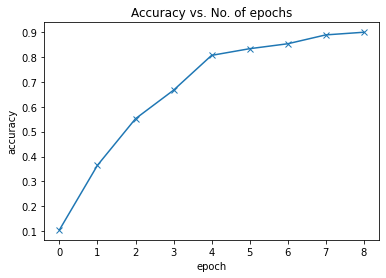

In [17]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")


plot_accuracies(history)

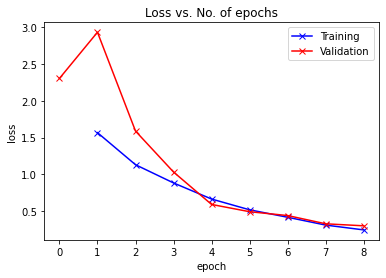

In [18]:
def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")


plot_losses(history)

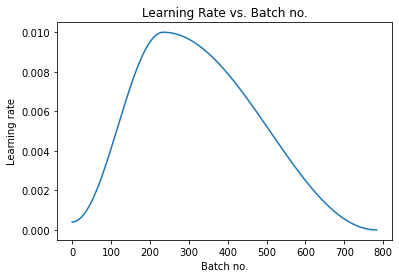

In [19]:
def plot_lrs(history):
    lrs = np.concatenate([x.get("lrs", []) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch no.")
    plt.ylabel("Learning rate")
    plt.title("Learning Rate vs. Batch no.")


plot_lrs(history)

Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:

- **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

- **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

- **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

- **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

- **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

- **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

- **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training. [Learn more](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

- **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more](https://ruder.io/optimizing-gradient-descent/index.html)